In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, start=0, end=None, format='-'):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Series')
    plt.grid(True)

In [3]:
def trend(time, slope=0):
    return slope * time

In [4]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

In [5]:
from random import randrange

def white_noise (time):
    series = np.random.randn(len(time))
    return series

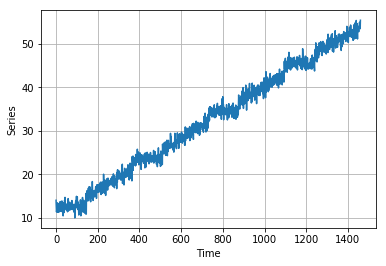

In [6]:
time = np.arange(4 * 365 + 1, dtype="float32")

baseline = 10
slope = 0.03
amplitude = 2

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += white_noise(time)

plot_series (time, series)

In [7]:
split_point = 1000
window_size = 20
window_shift_size = 1
shuffle_buffer = 900
batch_size = 32

time_train = time[0:split_point]
series_train = series[0:split_point]

time_val = time[split_point:]
series_val = series[split_point:]

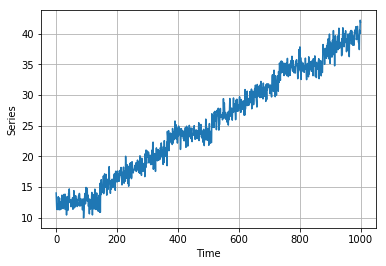

In [8]:
plot_series (time_train, series_train)

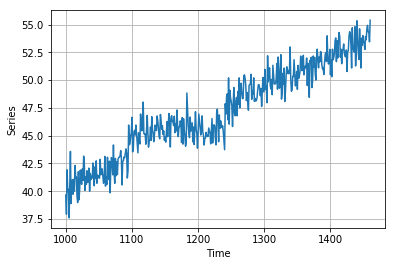

In [9]:
plot_series (time_val, series_val)

In [10]:
def windowed_dataset(series, window_size, shift_size, shuffle_buffer, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.shuffle(buffer_size=shuffle_buffer)
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True).prefetch(1)
    print (dataset)
    return dataset

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(series_train, window_size, window_shift_size, shuffle_buffer, batch_size)

W0812 18:20:31.218165 15912 deprecation.py:323] From C:\MachineLearning\anaconda\lib\site-packages\tensorflow\python\data\util\random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<PrefetchDataset shapes: ((32, None), (32, None)), types: (tf.float32, tf.float32)>


## Configure Callbacks which would be executed during the training phase

In [12]:
def create_callbacks():
    callbacks = [
        tf.keras.callbacks.LearningRateScheduler(lambda epochs: 1e-8 * 10**(epochs/20))
        #tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.01, patience=5)
    ]
    return callbacks

cbk = create_callbacks()

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Here we try to get the ideal value of the Learning Rate using a LearningRateScheduler callback and Huber loss function.
#model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae'])
history = model.fit(dataset, epochs=200, verbose=1, callbacks=cbk)

Epoch 1/200
30/30 [==============================] - 9s 298ms/step - loss: 13.1451 - mae: 13.6297
Epoch 2/200
30/30 [==============================] - 1s 46ms/step - loss: 13.0345 - mae: 13.5202
Epoch 3/200
30/30 [==============================] - 1s 45ms/step - loss: 12.9033 - mae: 13.3904
Epoch 4/200
30/30 [==============================] - 1s 45ms/step - loss: 12.7597 - mae: 13.2475
Epoch 5/200
30/30 [==============================] - 1s 47ms/step - loss: 12.6029 - mae: 13.0918
Epoch 6/200
30/30 [==============================] - 1s 47ms/step - loss: 12.4319 - mae: 12.9224
Epoch 7/200
30/30 [==============================] - 1s 48ms/step - loss: 12.2451 - mae: 12.7371
Epoch 8/200
30/30 [==============================] - 1s 46ms/step - loss: 12.0410 - mae: 12.5341
Epoch 9/200
30/30 [==============================] - 1s 46ms/step - loss: 11.8179 - mae: 12.3109
Epoch 10/200
30/30 [==============================] - 1s 47ms/step - loss: 11.5745 - mae: 12.0678
Epoch 11/200
30/30 [========

30/30 [==============================] - 1s 48ms/step - loss: 1.2446 - mae: 1.6798
Epoch 86/200
30/30 [==============================] - 1s 48ms/step - loss: 0.8973 - mae: 1.3187
Epoch 87/200
30/30 [==============================] - 2s 51ms/step - loss: 1.1312 - mae: 1.5642
Epoch 88/200
30/30 [==============================] - 1s 48ms/step - loss: 4.3070 - mae: 4.7923
Epoch 89/200
30/30 [==============================] - 1s 48ms/step - loss: 2.7157 - mae: 3.1848
Epoch 90/200
30/30 [==============================] - 1s 46ms/step - loss: 1.3611 - mae: 1.8031
Epoch 91/200
30/30 [==============================] - 1s 45ms/step - loss: 1.6225 - mae: 2.0747
Epoch 92/200
30/30 [==============================] - 1s 45ms/step - loss: 1.2083 - mae: 1.6425
Epoch 93/200
30/30 [==============================] - 1s 46ms/step - loss: 1.6976 - mae: 2.1491
Epoch 94/200
30/30 [==============================] - 1s 46ms/step - loss: 2.5550 - mae: 3.0180
Epoch 95/200
30/30 [==============================] -

30/30 [==============================] - 1s 44ms/step - loss: 21444.0296 - mae: 21444.5293
Epoch 167/200
30/30 [==============================] - 1s 44ms/step - loss: 19741.1641 - mae: 19741.6641
Epoch 168/200
30/30 [==============================] - 1s 43ms/step - loss: 34198.3632 - mae: 34198.8633
Epoch 169/200
30/30 [==============================] - 1s 43ms/step - loss: 20738.0344 - mae: 20738.5332
Epoch 170/200
30/30 [==============================] - 1s 44ms/step - loss: 24490.3994 - mae: 24490.8984
Epoch 171/200
30/30 [==============================] - 1s 43ms/step - loss: 48039.8952 - mae: 48040.3906
Epoch 172/200
30/30 [==============================] - 1s 43ms/step - loss: 32434.8967 - mae: 32435.3965
Epoch 173/200
30/30 [==============================] - 1s 44ms/step - loss: 50565.3174 - mae: 50565.8203
Epoch 174/200
30/30 [==============================] - 1s 43ms/step - loss: 34568.0384 - mae: 34568.5352
Epoch 175/200
30/30 [==============================] - 1s 43ms/step -

dict_keys(['loss', 'mae', 'lr'])


[1e-08, 0.0001, 0, 30]

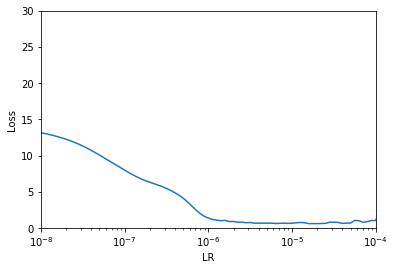

In [15]:
print (history.history.keys())
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel('LR')
plt.ylabel('Loss')
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae'])
#model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber(), metrics=['mae'])
history = model.fit(dataset, epochs=5000, verbose=1)

## Visualizing the training metadata

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = plt.figure()

training_loss = history.history['loss']
training_accuracy = history.history['mean_squared_error']
training_epochs = range(len(training_loss))

ax1 = figure.add_subplot(211)
ax1.plot(training_epochs, training_loss)
ax1.plot(training_epochs, training_accuracy)
plt.title('MSE & Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE & Loss')
plt.legend(labels=['Loss','MSE'])

plt.show()

## Visualizing the training metadata - ZOOMED IN

In [ ]:
zoomed_in_loss = training_loss[10:]
zoomed_in_acc = training_accuracy[10:]
zoomed_in_epochs = training_epochs[10:]

figure = plt.figure()

ax1 = figure.add_subplot(212)
ax1.plot(zoomed_in_epochs, zoomed_in_loss)
ax1.plot(zoomed_in_epochs, zoomed_in_acc)
plt.title('MSE & Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE & Loss')
plt.legend(labels=['Loss','MSE'], loc=0)

plt.show()

In [ ]:
forecast = []
print ('Length of series is ',len(series))
print ('Window size is ', window_size)
for x in range(len(series)-window_size):
    forecast.append(model.predict(series[x:x+window_size][np.newaxis]))
    
# forecast is on entire series data. let's remove the data which was part of training and keep just the forecast for validation data
forecast = forecast[split_point-window_size:]

In [ ]:
results = np.array(forecast)[:,0,0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_val, series_val)
plot_series(time_val, results)

In [ ]:
tf.keras.metrics.mean_squared_error(series_val, results).numpy()